In [1]:
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
import gammapy
import json
# from gammapy.datasets import MapDataset
from gammapy.maps import Map
from astropy.coordinates import SkyCoord, Angle
from gammapy.modeling import Fit, Parameter, Parameters, Covariance
from gammapy.datasets import MapDataset #, MapDatasetNuisance
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    create_crab_spectral_model,
    SkyModel,
    PointSpatialModel,
    ShellSpatialModel,
    GeneralizedGaussianSpatialModel,
    TemplateSpatialModel,
    LogParabolaSpectralModel,
    GaussianSpatialModel,
    DiskSpatialModel,
    PowerLawNormSpectralModel,
    Models,
    SpatialModel,
    FoVBackgroundModel,
    Model
)
from gammapy.estimators import ExcessMapEstimator

from regions import CircleSkyRegion, RectangleSkyRegion
import yaml
import sys

sys.path.append(
    "/home/hpc/caph/mppi045h/3D_analysis/N_parameters_in_L/syserror_3d_bkgmodel/4-Fitting_nuisance_and_model_parameters"
)
sys.path.append(
    "/home/hpc/caph/mppi045h/3D_analysis/"
)
from my_dataset_maps_19 import MapDatasetNuisance
from  my_fit_19 import Fit
import import_helper

In [2]:




def plot_significance(analysis):
    fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True, gridspec_kw={'height_ratios': [3, 1]})
    analysis.significance()
    analysis.success ()
    for i ,ax in enumerate(analysis.amplitudes_x):
        if analysis.success_standard[i]:
            color = 'green'
        else:
            color = 'red'
        ax1.plot(ax, analysis.TS_standard[i], 'o', color= color)

        if analysis.success_N[i]:
            color = 'green'
        else:
            color = 'red'
        ax1.plot(ax, analysis.TS_N[i], 'x', color= color,
                    markersize = 16)
    ax1.set_yscale('log'); 
    ax1.legend()
    ax1.set_ylabel("Significance [$\sigma$]")
    ax1.set_title(analysis.title)

    res =  np.array(analysis.TS_standard) - np.array(analysis.TS_N)
    ax2.plot(analysis.amplitudes_x, res, 'o', color= 'black')
    ax2.set_ylabel("$\sigma_{Standard} - \sigma_{Nuisance}$")
    ax2.set_xlabel("Input Amplitudes [$10^{-12}$ cm-2 s-1 TeV-1]")
    #ax2.hlines(0, xlim_all[0], xlim_all[1], color = 'grey')
    #ax2.grid();  ax1.grid();

    return plt.gcf(), ax1, ax2

def plot_amplitudes(analysis):
    analysis.best_fit_amplitudes()
    fig, ax = plt.subplots(1,1, )#figsize =(10,10))
    ax = [ax]
    color = 'red'
    ax[0].errorbar(np.array(analysis.amplitudes_x) - 0.3,analysis.ampli_standard,
                   yerr = np.array(analysis.err_standard), fmt ='x', color= 'green', markersize = 16)
    ax[0].errorbar(np.array(analysis.amplitudes_x) - 0.15,  analysis.ampli_N_under,
                   yerr = np.array(analysis.err_N_under) ,fmt =  'o', color= colors_case[0], markersize = 8)

    ax[0].errorbar(analysis.amplitudes_x, analysis.ampli_N,
                   yerr = np.array(analysis.err_N) , fmt = 'o', color= colors_case[1], markersize = 8)
    ax[0].errorbar(np.array(analysis.amplitudes_x) + 0.15,  analysis.ampli_N_over,
                   yerr = np.array(analysis.err_N_over) ,fmt =  'o', color= colors_case[2], markersize = 8)

    fmt = 'o:'
    xlim = ax[0].set_xlim(); 
    ax[0].errorbar([0], [0], yerr= [0] ,fmt= 'x',color = 'green' ,label="Standard", markersize = 16)
    ax[0].plot([0], [0], 'o',color = colors_case[0] ,label="Nuisance Under", markersize = 8)
    ax[0].plot([0], [0], 'o',color = colors_case[1] ,label="Nuisance Corr", markersize = 8)
    ax[0].plot([0], [0], 'o',color = colors_case[2] ,label="Nuisance Over", markersize = 8)

    ax[0].set_ylim(ylim_ampli); 
    #xlim = ax[0].set_xlim(xlim_all[0], xlim_all[1]); 
    ax[0].set_xlabel("Random Draw Number")
    ax[0].set_ylabel("Best Fit Amplitude \n [Input Amplitude]")
    ax[0].hlines(1, analysis.amplitudes_x[0], analysis.amplitudes_x[-1], color = "grey")
    ax[0].legend()
    ax[0].set_title(analysis.title)

def plot_norm(analysis ):
    analysis.best_fit_norm()
    fig, ax = plt.subplots(1,1, )#figsize =(10,10))
    ax = [ax]
    color = 'red'
    print("analysis.norm_err_standard", analysis.norm_err_standard)
    print("analysis.norm_x_mins_N", analysis.norm_err_N)

    ax[0].errorbar(np.array(analysis.amplitudes_x) - 0.3,analysis.norm_standard,
                   yerr = np.array(analysis.norm_err_standard), fmt ='x', color= 'green', markersize = 16)
    ax[0].errorbar(np.array(analysis.amplitudes_x) - 0.15,  analysis.norm_N_under,
                   yerr = np.array(analysis.norm_err_N_under) ,fmt =  'o', color= colors_case[0], markersize = 8)

    ax[0].errorbar(analysis.amplitudes_x, analysis.norm_N,
                   yerr = np.array(analysis.norm_err_N) , fmt = 'o', color= colors_case[1], markersize = 8)
    ax[0].errorbar(np.array(analysis.amplitudes_x) + 0.15,  analysis.norm_N_over,
                   yerr = np.array(analysis.norm_err_N_over) ,fmt =  'o', color= colors_case[2], markersize = 8)

    fmt = 'o:'
    ax[0].set_xscale('log')
    xlim = ax[0].set_xlim(); 
    ax[0].errorbar([0], [0], yerr= [0] ,fmt= 'x',color = 'green' ,label="Standard", markersize = 16)
    ax[0].plot([0], [0], 'o',color = colors_case[0] ,label="Nuisance Under", markersize = 8)
    ax[0].plot([0], [0], 'o',color = colors_case[1] ,label="Nuisance Corr", markersize = 8)
    ax[0].plot([0], [0], 'o',color = colors_case[2] ,label="Nuisance Over", markersize = 8)
    ax[0].set_ylim(ylim_norm) ; 
    x_ = ax[0].get_xlim()
    xlim = ax[0].set_xlim(x_[0], x_[1]); 

    ax[0].set_xlabel("Random Draw Number")
    ax[0].set_ylabel("Best Fit Norm \n [Input Norm]")
    ax[0].hlines(1, analysis.amplitudes_x[0], analysis.amplitudes_x[-1], color = "grey")
    ax[0].legend(ncol = 2)
    ax[0].set_title(analysis.title)



In [3]:
source = "Crab"
added = '_008'
ebins = range(6,20)
outputfolder = 'output/data_asimov_tests'



plotaa= '/home/hpc/caph/mppi045h/3D_analysis/N_parameters_in_L/syserror_3d_bkgmodel/4-Fitting_nuisance_and_model_parameters/Asimov/plots'

In [4]:
ylim_sig = (0.2, 5e4)
ylim_ampli = (0.5, 1.5)
ylim_norm= (0.98, 1.02)
ylim_L_scan = (-0.3,2)
#xlim_all = (0.005623413251903491, 1778.2794100389228)
xlim_all = (0.005623413251903491, 100)
colors_case = ['darkorange', 'red', 'maroon', 'grey', 'grey']
fmts = ['^', 'o',  'x', 's']
color_overall_standard = 'green'
label = 'Correct Est. ($\mu$ +  $\sigma$)'
labelunder = "Under Est. ($\mu$ + 0.5 $\cdot$ $\sigma$)"
labelover =  "Over Est. ($\mu$ + 2 $\cdot$ $\sigma$)"
labelstandard = "No Nuisance Par. "

## Point Source

/home/hpc/caph/mppi045h/anaconda3/envs/gammapy-0.19/lib/python3.9/site-packages/matplotlib/axes/_base.py:2283: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)
/home/hpc/caph/mppi045h/anaconda3/envs/gammapy-0.19/lib/python3.9/site-packages/matplotlib/axes/_base.py:2283: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


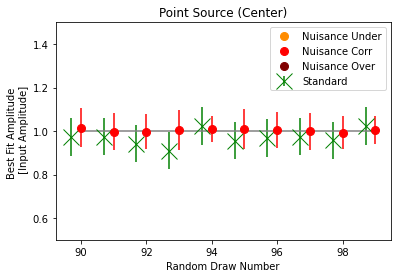

In [5]:
rnds = [ 90,91,92,93,94,95,96,97, 98, 99]

amplitude = 1e-12
analysis_point_624 = import_helper.analysis('pointsource_center_624', amplitude, rnds, False)
analysis_point_624.best_fit_amplitudes()
plot_amplitudes(analysis_point_624)

Text(1.075, 0, 'N=10')

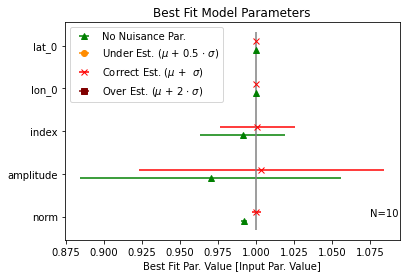

In [6]:
par_names = ['norm', 'amplitude', 'index', 'lon_0', 'lat_0']
par_input = dict()
par_input['norm'] = 1
par_input['tilt'] = 1
par_input['amplitude'] = 1e-12
par_input['index'] = 2.4
par_input['lon_0'] = 83.6
par_input['lat_0'] = 22.0

for i, par_name in enumerate(par_names):
    tupel = analysis_point_624.get_parameters(par_name)
    if par_name == 'tilt':
        tupel = np.array(tupel) +1 
    tupel = np.array(tupel) / par_input[par_name]
    (mean_par_standard, mean_par_err_standard, mean_par_N_under, mean_par_err_N_under, mean_par_N, mean_par_err_N, mean_par_N_over,mean_par_err_N_over) = tupel
    if i ==0:
        label = 'Correct Est. ($\mu$ +  $\sigma$)'
        labelunder = "Under Est. ($\mu$ + 0.5 $\cdot$ $\sigma$)"
        labelover =  "Over Est. ($\mu$ + 2 $\cdot$ $\sigma$)"
        labelstandard = "No Nuisance Par. "
    else:
        label, labelunder, labelover, labelstandard = '' ,'','', ''
    plt.errorbar(y = i-0.1, x =mean_par_standard, xerr =  mean_par_err_standard, fmt = fmts[0],
                color = color_overall_standard, label = labelstandard)
    plt.errorbar(y = i+0, x =mean_par_N_under, xerr =  mean_par_err_N_under, fmt = fmts[1], 
                 color = colors_case[0], label = labelunder)
    plt.errorbar(y = i+0.1, x =mean_par_N, xerr =  mean_par_err_N, fmt = fmts[2], 
                 color = colors_case[1], label = label)
    plt.errorbar(y = i+0.2, x =mean_par_N_over, xerr =  mean_par_err_N_over, fmt = fmts[3],
                 color = colors_case[2], label = labelover)
    
plt.xlabel('Best Fit Par. Value [Input Par. Value]')
plt.yticks(np.linspace(0, len(par_names)-1, len(par_names) ),
          par_names)
plt.legend()
ylim  = plt.ylim()
plt.vlines(1, ylim[0], ylim[1], color = 'grey')
plt.title('Best Fit Model Parameters')
plt.text(1.075,0, f"N={len(rnds)}")

analysis.norm_err_standard [0.0019298122666929994, 0.001929036123383666, 0.0019312968363584893, 0.0019276312505932258, 0.0019332424891800382, 0.0019289572946666789, 0.0018719026420139868, 0.0019279756208419785, 0.0019290256522730676, 0.0019300823144367224]
analysis.norm_x_mins_N [0.0028078382504555716, 0.0028097862787224734, 0.0028034386653461698, 0.002803546933638136, 0.0028056687055694656, 0.0028038844606513413, 0.002805497324780668, 0.0028058219800234777, 0.0028071018104233667, 0.002804464582055364]


/home/hpc/caph/mppi045h/anaconda3/envs/gammapy-0.19/lib/python3.9/site-packages/matplotlib/axes/_base.py:2283: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)
/home/hpc/caph/mppi045h/anaconda3/envs/gammapy-0.19/lib/python3.9/site-packages/matplotlib/axes/_base.py:2283: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


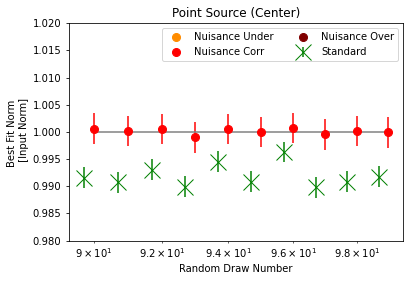

In [7]:
amplitude = 1e-12
analysis_point_624 = import_helper.analysis('pointsource_center_624', amplitude,rnds, False)
analysis_point_624.best_fit_norm()
plot_norm(analysis_point_624)

No handles with labels found to put in legend.


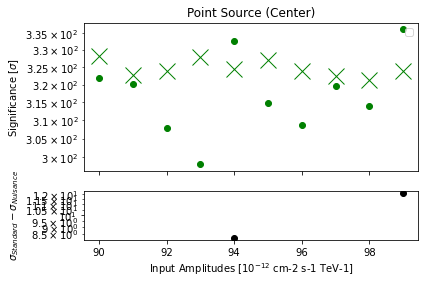

In [8]:
fig, ax1, ax2 = plot_significance(analysis_point_624)
ax = plt.gca(); ylim = ax1.get_ylim()

#xxlim = ax1.get_xlim()
ax2.set_yscale('log')
plt.show()


/home/hpc/caph/mppi045h/anaconda3/envs/gammapy-0.19/lib/python3.9/site-packages/matplotlib/axes/_base.py:2283: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


Text(0.5, 1.0, 'Significance Sqrt TS')

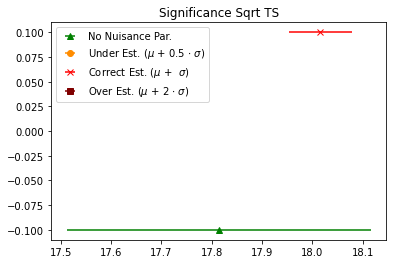

In [9]:
mean_TS_standard = np.mean(np.sqrt(analysis_point_624.TS_standard))
std_TS_standard = np.std(np.sqrt(analysis_point_624.TS_standard))
mean_TS_N_under = np.mean(np.sqrt(analysis_point_624.TS_N_under))
std_TS_N_under = np.std(np.sqrt(analysis_point_624.TS_N_under))
mean_TS_N = np.mean(np.sqrt(analysis_point_624.TS_N))
std_TS_N = np.std(np.sqrt(analysis_point_624.TS_N))
mean_TS_N_over = np.mean(np.sqrt(analysis_point_624.TS_N_over))
std_TS_N_over = np.std(np.sqrt(analysis_point_624.TS_N_over))


for i, t in enumerate([0]):
    if i ==0:
        label = 'Correct Est. ($\mu$ +  $\sigma$)'
        labelunder = "Under Est. ($\mu$ + 0.5 $\cdot$ $\sigma$)"
        labelover =  "Over Est. ($\mu$ + 2 $\cdot$ $\sigma$)"
        labelstandard = "No Nuisance Par. "
    else:
        label, labelunder, labelover, labelstandard = '' ,'','', ''
    plt.errorbar(y = i-0.1, x =mean_TS_standard, xerr =  std_TS_standard, fmt = fmts[0],
                color = color_overall_standard, label = labelstandard)
    plt.errorbar(y = i+0, x =mean_TS_N_under, xerr =  std_TS_N_under, fmt = fmts[1], 
                 color = colors_case[0], label = labelunder)
    plt.errorbar(y = i+0.1, x =mean_TS_N, xerr =  std_TS_N, fmt = fmts[2], 
                 color = colors_case[1], label = label)
    plt.errorbar(y = i+0.2, x =mean_TS_N_over, xerr =  std_TS_N_over, fmt = fmts[3],
                 color = colors_case[2], label = labelover)
    
plt.legend()
ylim  = plt.ylim()
plt.title('Significance Sqrt TS')


Text(0.5, 1.0, 'Significance')

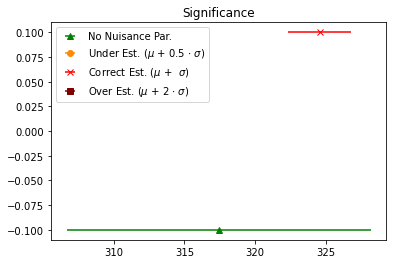

In [10]:
mean_TS_standard = np.mean(analysis_point_624.TS_standard)
std_TS_standard = np.std(analysis_point_624.TS_standard)
mean_TS_N_under = np.mean(analysis_point_624.TS_N_under)
std_TS_N_under = np.std(analysis_point_624.TS_N_under)
mean_TS_N = np.mean(analysis_point_624.TS_N)
std_TS_N = np.std(analysis_point_624.TS_N)
mean_TS_N_over = np.mean(analysis_point_624.TS_N_over)
std_TS_N_over = np.std(analysis_point_624.TS_N_over)


for i, t in enumerate([0]):
    if i ==0:
        label = 'Correct Est. ($\mu$ +  $\sigma$)'
        labelunder = "Under Est. ($\mu$ + 0.5 $\cdot$ $\sigma$)"
        labelover =  "Over Est. ($\mu$ + 2 $\cdot$ $\sigma$)"
        labelstandard = "No Nuisance Par. "
    else:
        label, labelunder, labelover, labelstandard = '' ,'','', ''
    plt.errorbar(y = i-0.1, x =mean_TS_standard, xerr =  std_TS_standard, fmt = fmts[0],
                color = color_overall_standard, label = labelstandard)
    plt.errorbar(y = i+0, x =mean_TS_N_under, xerr =  std_TS_N_under, fmt = fmts[1], 
                 color = colors_case[0], label = labelunder)
    plt.errorbar(y = i+0.1, x =mean_TS_N, xerr =  std_TS_N, fmt = fmts[2], 
                 color = colors_case[1], label = label)
    plt.errorbar(y = i+0.2, x =mean_TS_N_over, xerr =  std_TS_N_over, fmt = fmts[3],
                 color = colors_case[2], label = labelover)
    
plt.legend()
ylim  = plt.ylim()
plt.title('Significance')


## Nuisance

In [11]:

path_local_repo_saturn = '/home/saturn/caph/mppi045h/Nuisance_Asimov_Datasets'


In [12]:
## Models
point_spatial_model_asimov = PointSpatialModel(lon_0=83.6*u.deg, 
                                             lat_0=22.0*u.deg, 
                                             frame='icrs')
    
gaussian_spatial_model_asimov = GaussianSpatialModel(lon_0=83.6*u.deg, 
                                             lat_0=22.0*u.deg, 
                                            sigma = 0.5 *u.deg,
                                             frame='icrs')
gaussian_off_spatial_model_asimov = GaussianSpatialModel(lon_0=83.6*u.deg + 1*u.deg, 
                                             lat_0=22.0*u.deg + 1*u.deg, 
                                            sigma = 0.5 *u.deg,
                                             frame='icrs')
gaussian_large_spatial_model_asimov = GaussianSpatialModel(lon_0=83.6*u.deg, 
                                                 lat_0=22.0*u.deg, 
                                                sigma = 2 *u.deg,
                                                 frame='icrs') 


spatial_model_d = dict()
spatial_model_d['pointsource_center'] = point_spatial_model_asimov


In [13]:
def get_circ_mask(geom , radius ):
    center_coord = geom.center_skydir
    #radius = 2*u.deg
    skyregion = CircleSkyRegion(center=center_coord, radius = radius)
    map_mask= Map.from_geom(geom, 
                                data=geom.region_mask([skyregion], inside=True).data)
    return map_mask

def read_mock_dataset(ad ):
    added = "_" + str(ad)
    dataset_N_sys = MapDatasetNuisance.read(f'{path_local_repo_saturn}/nui_dataset{added}.fits')
    with open(f'{path_local_repo_saturn}/nui_par{added}.yml', "r") as ymlfile:
        nui_par = yaml.load(ymlfile, Loader=yaml.FullLoader)
    dataset_N_sys.N_parameters = Parameters.from_dict(nui_par )
    bkg_model = FoVBackgroundModel(dataset_name=dataset_N_sys.name)
    models = Models([])
    models.append(bkg_model)
    dataset_N_sys.models =models
    return dataset_N_sys

class mocked_dataset():
    def __init__(self,spatial_model_type, amplitude, rnd):
        self.amplitude = amplitude
        self.rnd  = rnd
        self.spatial_model_type = spatial_model_type
        self.dataset_N_sys = self.dataset_N_sys()
        
    def model_input(self):
        spatial_model = spatial_model_d[self.spatial_model_type]
        spectral_model_asimov = PowerLawSpectralModel(index=2.4,
                                              amplitude=self.amplitude, 
                                              reference="1 TeV") 
        model_input = SkyModel(spatial_model=spatial_model, 
                                 spectral_model=spectral_model_asimov, 
                                 name="source")
        return model_input  
    
    def sys_map(self):
        dataset_N_sys = self.dataset_N_sys.copy()
        sys_map = dataset_N_sys.N_map().copy()
        for e in range(24):
            ex = dataset_N_sys.exposure
            ex_ = ex.slice_by_idx(dict(energy_true= slice(e, e+1)))
            ex_.data = ex_.data / np.max(ex_.data)
            sys_map.slice_by_idx(dict(energy= slice(e, e+1))).data *= ex_.data
        return sys_map
    
    def npred_background(self):
        sys_map = self.sys_map()
        npred_background  = Map.from_geom(sys_map.geom)
        npred_background.data  = self.dataset_N_sys.background.data * (1+sys_map.data) 
        return npred_background
    
    def dataset_N_sys(self):
        dataset_N_sys = read_mock_dataset(self.rnd)
        dataset_N_sys.models = Models([self.model_input()])
        return dataset_N_sys

class fitted_datasets():
    def __init__(self,spatial_model_type, amplitude, rnd):
        self.amplitude = amplitude
        self.rnd  = rnd
        self.spatial_model_type = spatial_model_type
        self.outputfile = f'/OOutput{self.amplitude.value}.json'   
        self.mocked_dataset = mocked_dataset(spatial_model_type, amplitude, rnd)
        self.dataset_N_sys = self.mocked_dataset.dataset_N_sys
        
    def counts(self):
        npred = self.dataset_N_sys.npred_signal()
        npred.data += self.mocked_dataset.npred_background()
        return  npred
    
    def list_nuis(self):
        with open(f'{path_local_repo_saturn}/OOutput{self.amplitude.value}/nui_par_{self.rnd}.yml','r') as ymlfile:
            dict_nuis = yaml.load(ymlfile, Loader=yaml.FullLoader)
        list_nuis = []
        for case in dict_nuis.keys():
            list_nuis.append( Parameters.from_dict(dict_nuis[case] ))
        return list_nuis
    
    def result(self):
        with open(outputfolder+self.outputfile, 'r') as ymlfile:
             data = yaml.load(ymlfile, Loader=yaml.FullLoader)
        result = data[str(self.rnd)]['result']   
        return result
    
    def best_fit_models(self):
        model_input = self.dataset_N_sys.models[0].copy()
        best_fit_models = [model_input.copy(), model_input.copy(), model_input.copy(), model_input.copy()]
        result = self.result()
        par_names = model_input.parameters.names
        for i, par_name in enumerate(par_names):
            best_fit_models[0].parameters[par_name].value = result["best_fit_"+par_name+"_standard"] 
            best_fit_models[1].parameters[par_name].value = result["best_fit_"+par_name+"_N"] 
            best_fit_models[2].parameters[par_name].value = result["best_fit_"+par_name+"_N_under"] 
            best_fit_models[3].parameters[par_name].value = result["best_fit_"+par_name+"_N_over"] 
            
            best_fit_models[0].parameters[par_name].error =  result["best_fit_"+par_name+"_error_standard"] 
            best_fit_models[1].parameters[par_name].error =  result["best_fit_"+par_name+"_error_N"] 
            best_fit_models[2].parameters[par_name].error =  result["best_fit_"+par_name+"_error_N_under"] 
            best_fit_models[3].parameters[par_name].error =  result["best_fit_"+par_name+"_error_N_over"] 
        return best_fit_models
        
    def datasets(self):
        dataset_standard = self.dataset_N_sys.copy()
        dataset_corr = self.dataset_N_sys.copy()
        dataset_under = self.dataset_N_sys.copy()
        dataset_over = self.dataset_N_sys.copy()
        datasets = [dataset_standard, dataset_corr, dataset_under, dataset_over]
        list_nuis = self.list_nuis()
        best_fit_models = self.best_fit_models()
        cases = ['standard','N', "N_under", "N_over"]
        result = self.result()
        
        for i,d in enumerate(datasets):
            bkg_model = FoVBackgroundModel(dataset_name=d.name) 
            par_names = bkg_model.parameters.names
            case = cases[i]
            for par_name in par_names:
                bkg_model.parameters[par_name].value = result[f"best_fit_{par_name}_{case}"] 
                bkg_model.parameters[par_name].error = result[f"best_fit_{par_name}_error_{case}"] 
            
            models = Models([best_fit_models[i]])
            models.append(bkg_model)
            d.models = models
            d.counts = self.counts()
            if i >0: # do not set for standard dataset
                d.N_parameters = list_nuis[i-1]
            else:
                for n in d.N_parameters: # set all to zero:
                    n.value = 0
        return datasets

In [14]:
def create_basic_dataset(dataset):
    basic_dataset = MapDataset(models=None, 
                           counts=None, 
                           exposure=dataset.exposure, 
                           background=dataset.background, 
                           psf=dataset.psf, 
                           edisp=dataset.edisp, 
                           mask_safe=dataset.mask_safe, 
                           mask_fit=dataset.mask_fit, 
                           gti=dataset.gti, 
                           meta_table=dataset.meta_table, 
                           name="basic")
    return basic_dataset

def create_MapDataset(dataset):
    mapdatset = basic_dataset.copy()
    bkg_model = FoVBackgroundModel(dataset_name=mapdatset.name) 
    #bkg_model.parameters['norm'].value = dataset.background_model.parameters['norm'].value
    #bkg_model.parameters['tilt'].value = dataset.background_model.parameters['tilt'].value
    models = Models([dataset.models[0].copy()])
    models.append(bkg_model)
    mapdatset.models = models
    mapdatset.counts = dataset.counts
    mapdatset.background = dataset.npred_background()
    return mapdatset

def compute_residual(dataset, energy_edges ,  max_ = None, radius = 1.0*u.deg,  ):
    
    estimator = ExcessMapEstimator( correlation_radius=radius , 
                                       energy_edges=energy_edges) 
    result = estimator.run(dataset) 
    residual = result["sqrt_ts"]#.slice_by_idx(dict(energy=slice(e,e+1)))

    if max_ is None:
        vmax = np.nanmax(np.abs(residual.data))
    else:
        vmax = max_
    return residual

In [15]:
datasets_standard = []
datasets_corr =[]
datasets_under = []
datasets_over =[]
for rnd in rnds:
    print(rnd)
    fitted_datasets_= fitted_datasets('pointsource_center', 
                                      1e-12*u.Unit('cm-2 s-1 TeV-1'),
                                      rnd )
    datasets = fitted_datasets_.datasets()
    datasets_standard.append(datasets[0])
    datasets_corr.append(datasets[1])
    datasets_under.append(datasets[2])
    datasets_over.append(datasets[3])
    


90
91
92
93
94
95
96
97
98
99


In [16]:
basic_dataset = create_basic_dataset(datasets_standard[0])

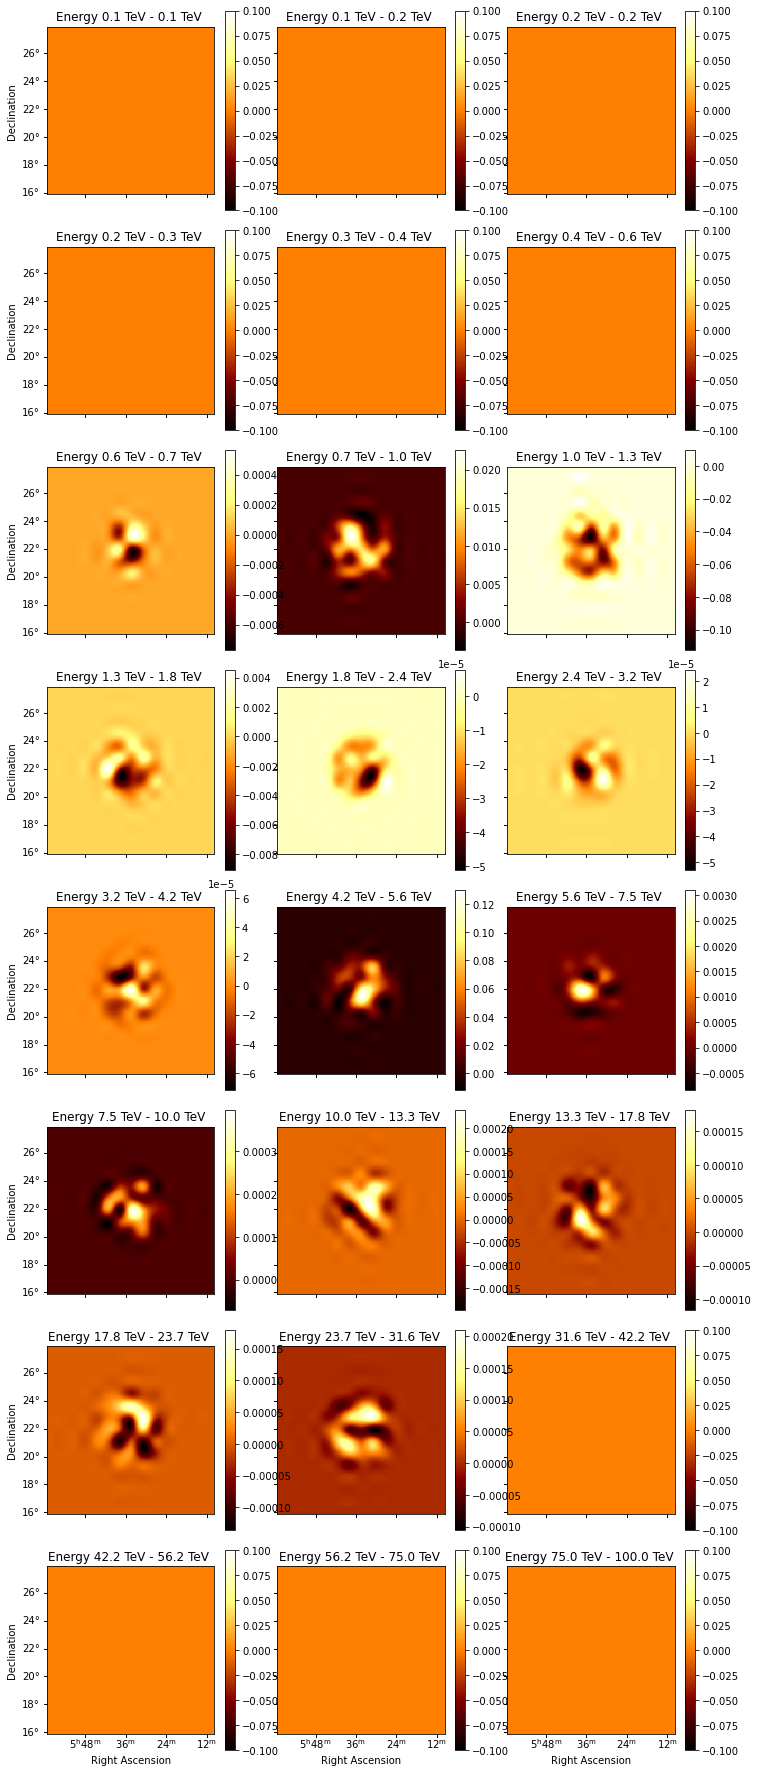

In [17]:
datasets_corr[-1].N_map().plot_grid(add_cbar =1);

90
91
92
93
94
95
96
97
98
99


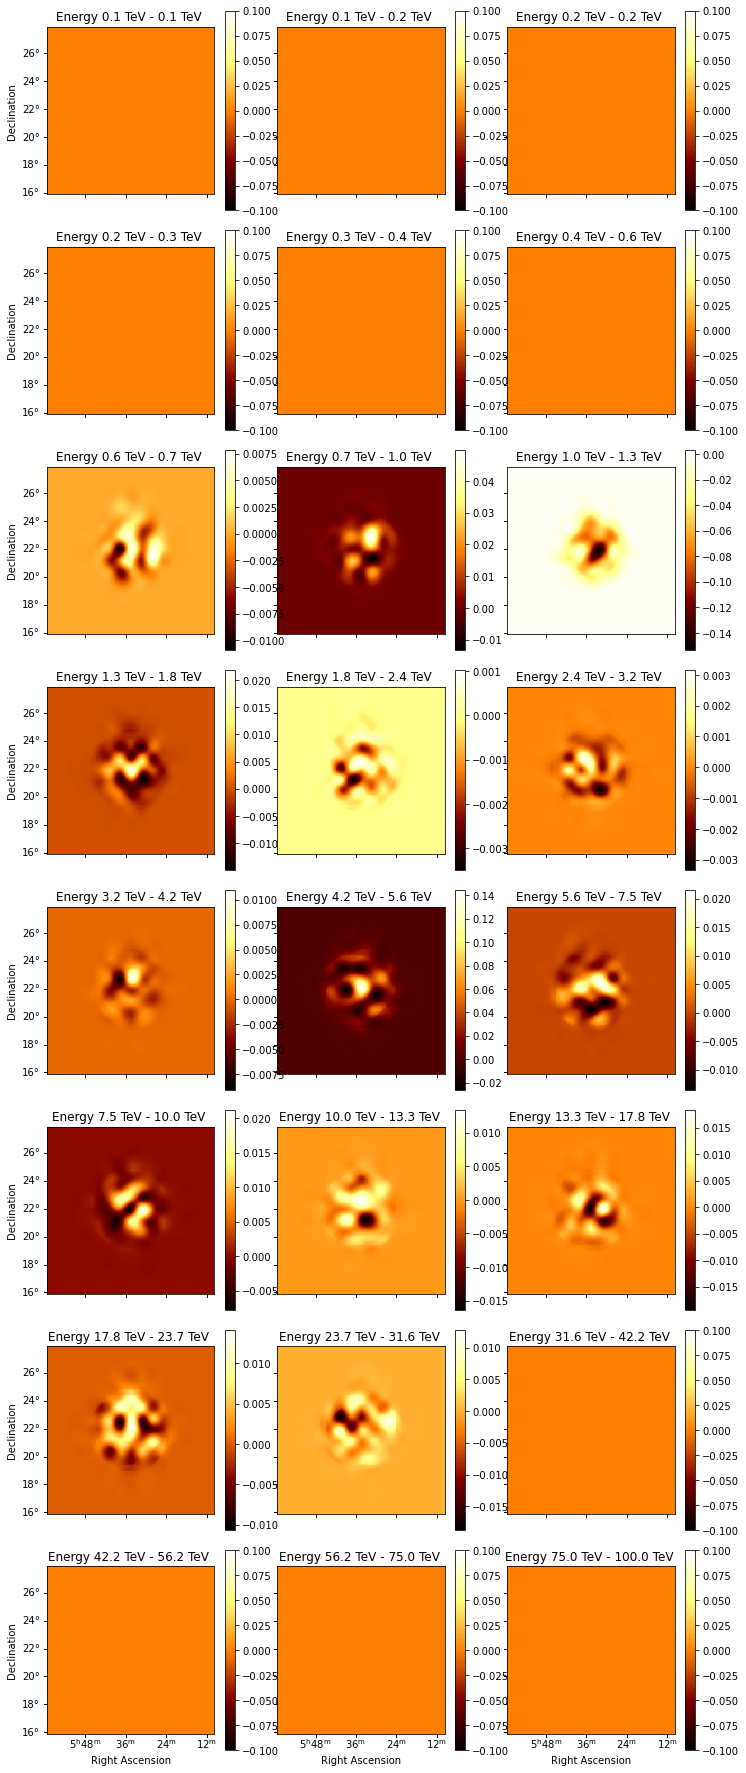

In [18]:
mocked_dataset_s = []
for rnd in rnds:
    print(rnd)
    mocked_dataset_ = mocked_dataset('pointsource_center',
                                 1e-12*u.Unit('cm-2 s-1 TeV-1'), rnd )
    mocked_dataset_s.append(mocked_dataset_)
sys_input = mocked_dataset_s[0].sys_map()
sys_input.plot_grid(add_cbar = 1);

In [19]:
i_start,i_end = 6,10
elist = np.linspace(i_start,i_end, i_end-i_start )

def plot_residuals(res, title, max_):
    data_zero = res#.slice_by_idx(dict(energy=slice(i_start,i_end)))
    if max_ is None:
        max_ = np.nanmax(np.abs(data_zero.data))
    axs = data_zero.plot_grid(add_cbar = 1,cmap = 'coolwarm', vmin = -max_, vmax = max_);
    axs = axs.flatten()
    #data_zero.data = np.nan_to_num(data_zero.data)
    mean = np.nanmean(data_zero, axis=2)
    mean = np.nanmean(mean, axis = 1)
    std = np.nanstd(data_zero, axis=2)
    std = np.nanstd(std, axis = 1)
    for i in range(len(mean)):
        axs.flatten()[i].text(10,35, f'{mean[i]:.2} $\pm$ {std[i]:.2}', fontsize = 12)
    plt.suptitle(title, 
                 fontsize = 14, y=1.01)
    return max_

[0.56234133 0.74989421 1.         1.33352143 1.77827941] TeV


/home/hpc/caph/mppi045h/anaconda3/envs/gammapy-0.19/lib/python3.9/site-packages/astropy/visualization/wcsaxes/core.py:211: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  return super().imshow(X, *args, origin=origin, **kwargs)
/tmp/ipykernel_3855/3410637886.py:11: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(data_zero, axis=2)
/home/hpc/caph/mppi045h/anaconda3/envs/gammapy-0.19/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


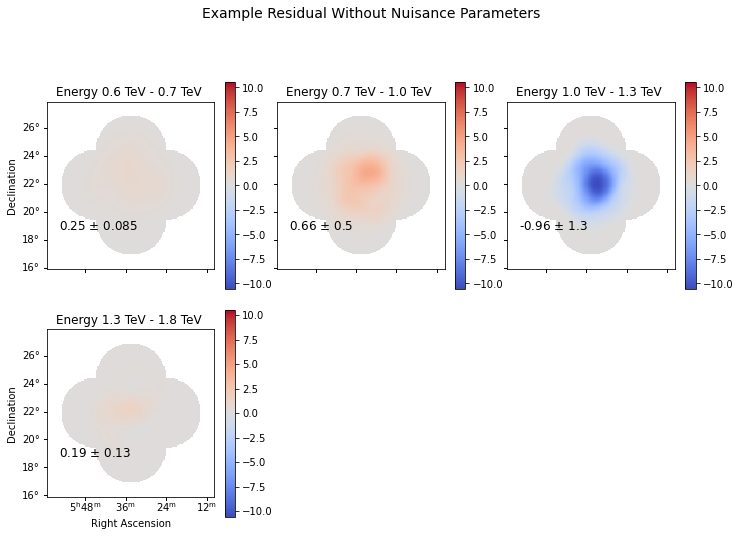

In [20]:
kk = -1
energy_edges = datasets_standard[kk].counts.geom.axes['energy'].edges[i_start:i_end+1]
print(energy_edges)
max_ = plot_residuals(compute_residual(create_MapDataset(datasets_standard[0]), energy_edges), 
                      "Example Residual Without Nuisance Parameters", None)



/home/hpc/caph/mppi045h/anaconda3/envs/gammapy-0.19/lib/python3.9/site-packages/astropy/visualization/wcsaxes/core.py:211: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  return super().imshow(X, *args, origin=origin, **kwargs)
/tmp/ipykernel_3855/3410637886.py:11: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(data_zero, axis=2)
/home/hpc/caph/mppi045h/anaconda3/envs/gammapy-0.19/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


10.573404

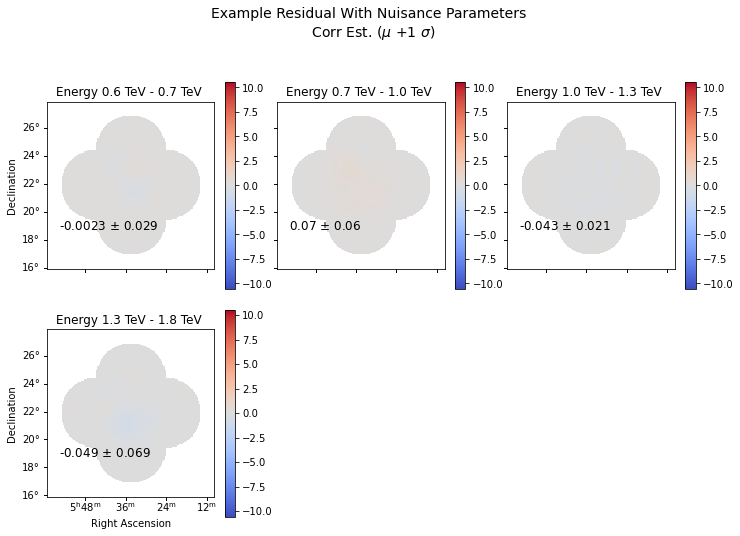

In [21]:
plot_residuals(compute_residual(create_MapDataset(datasets_corr[kk]), energy_edges), 
               "Example Residual With Nuisance Parameters \n Corr Est. ($\mu$ +1 $\sigma$)", max_)

/home/hpc/caph/mppi045h/anaconda3/envs/gammapy-0.19/lib/python3.9/site-packages/astropy/visualization/wcsaxes/core.py:211: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  return super().imshow(X, *args, origin=origin, **kwargs)
/tmp/ipykernel_3855/3410637886.py:11: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(data_zero, axis=2)
/home/hpc/caph/mppi045h/anaconda3/envs/gammapy-0.19/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


10.573404

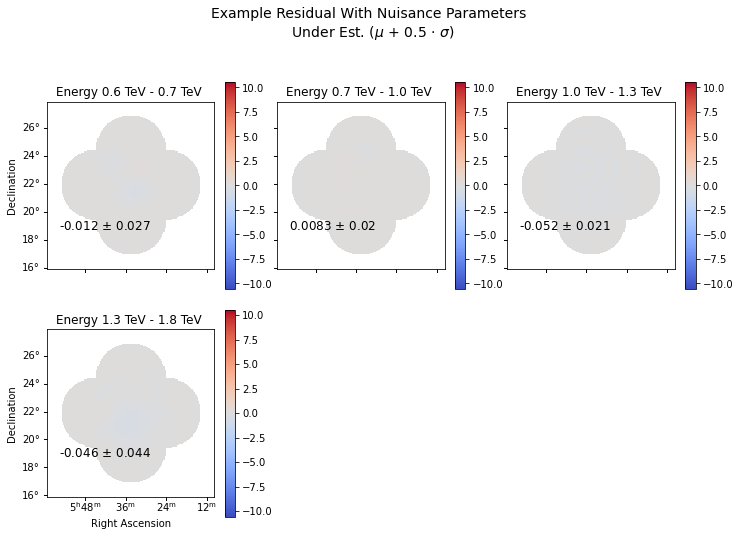

In [22]:
plot_residuals(compute_residual(create_MapDataset(datasets_under[kk]), energy_edges), 
               "Example Residual With Nuisance Parameters \n Under Est. ($\mu$ + 0.5 $\cdot$ $\sigma$)", max_)

/home/hpc/caph/mppi045h/anaconda3/envs/gammapy-0.19/lib/python3.9/site-packages/astropy/visualization/wcsaxes/core.py:211: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  return super().imshow(X, *args, origin=origin, **kwargs)
/tmp/ipykernel_3855/3410637886.py:11: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(data_zero, axis=2)
/home/hpc/caph/mppi045h/anaconda3/envs/gammapy-0.19/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


10.573404

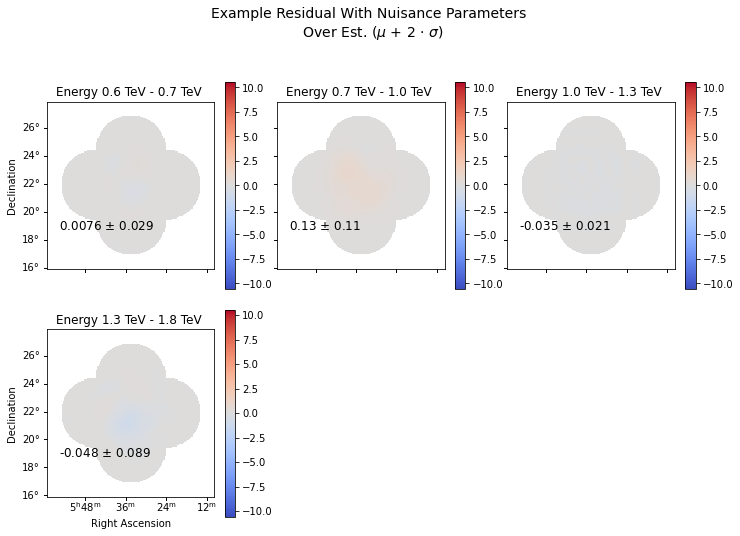

In [23]:
plot_residuals(compute_residual(create_MapDataset(datasets_over[kk]), energy_edges), 
               "Example Residual With Nuisance Parameters \n Over Est. ($\mu$ + 2 $\cdot$ $\sigma$)",max_)

In [24]:
from scipy.stats import ks_2samp

def get_data_to_plot(dataset,mocked ,type_, i_start, i_end):
    if type_ =='bgpred':
        if mocked is not None:
            data= mocked.npred_background() 
        else:
            data= dataset.npred_background() 
        #data -= dataset.background
        data *= get_circ_mask(data.geom , 2*u.deg )
        data = data.slice_by_idx(dict(energy = slice(i, i_end)))
        data = data.data.flatten()
        data = [d for d in data if d != 0]
        
        
    if type_ =='sys':
        if mocked is not None:
            data= mocked.sys_map()
        else:
            data= dataset.N_map()
        data *= get_circ_mask(data.geom , 2*u.deg )
        data = data.slice_by_idx(dict(energy = slice(i_start , i_end)))
        data = data.data.flatten()
        data = [d *100 for d in data if d != 0]
        
        
    if type_ =='nuipar':
        data = dataset.N_parameters.value[(i_start)*amount_free_par : (i_end)*amount_free_par]
        data = data * 100
    return data


def compute_ratio(dataset, mocked):
    if mocked is not None:
        npred= mocked.npred_background() 
    else:
        npred= dataset.npred_background() 
        
    sys = npred - dataset.background # in counts
    sys = np.abs(sys.data).sum(axis=2).sum(axis=1)
    stat = np.sqrt(dataset.background.data.sum(axis=2).sum(axis=1))
    return sys[i_start:i_end] /stat[i_start:i_end]

def plot_multiple_histo (tupels, elist, type_):
    fig, axs = plt.subplots(len(tupels), len(elist), 
                            figsize =(3 * len(elist),len(elist)* len(tupels))
                                      , sharex= True)
    for j, tupel in enumerate(tupels):
        if len(tupels)==1:
            axs = [axs]
        ax_ = axs[j]
        dataset_fitting = tupel[0]
        mocked = tupel[1]
        dataset = mocked.dataset_N_sys
        mus = tupel[2]
        stds = tupel[3]
        amount_free_par = 16 
        count_ = int(0)
        ratio = compute_ratio(dataset, mocked)
        print(ratio)
        
        for i,e in enumerate(xaxis[i_start:i_end]):
            i =i +i_start
            #ax = ax_.flatten()[i-i_start]
            ax = ax_[i-i_start]
            
            if type_ =="bgpred":
                pos = 70,100
                xlabel = 'Predicted BG Counts'
                i_ = i
            if type_=="nuipar":
                pos = 9,2
                i_ = i-i_start
                xlabel = 'Nuisance Parameters [% of BG]'
                s = np.random.normal(mu, sigma_, int(amount_free_par))
            if type_=='sys':
                pos= 7,100
                i_ = i
                xlabel = 'Nmap [% of BG]'
                

            input_ =  get_data_to_plot(dataset,    mocked,  type_, i_, i_+1)
            rec = get_data_to_plot(dataset_fitting, None, type_, i_, i_+1)
            
            KS, p = ks_2samp(input_, rec, alternative='two-sided',)
            
            count, bins, ignored = ax.hist(input_, 10, density=False, alpha = 0.3, color = 'red',
                                          label = "Input")
            KS, p = ks_2samp(input_, rec, alternative='two-sided', )
            ax.hist(rec, bins = bins, alpha = 0.3, label = f'Recovered \n(p-value: {p:.2})')
            
            count, bins, ignored = ax.hist(input_, 10, density=False, alpha = 0.3, color = 'red',
                                          label = '')
            if type_=="nuipar":
                ax.plot(bins,   max(count) *
                                    np.exp( - (bins - 0)**2 / (2 * stds[i]**2) ),
                              linewidth=2, color='green')
                ylim = ax.get_ylim()
                ax.vlines(0 +stds[i], ylim[0], ylim[1],color = 'red' )
                ax.vlines(0 -stds[i], ylim[0], ylim[1],color = 'red')
            
            
            if j == (len(tupels)-1):
                ax.set_title(f'Ratio (sys/stat): {(ratio[i-i_start]):.3}')
                ax.set_xlabel(xlabel)
            else:
                ax.set_title(f'Energy: {xaxis[i].value:.2} TeV \n Ratio (sys/stat): {(ratio[i-i_start]):.2}')
                
            ax.legend(loc = "upper center")
            ax.set_yscale('log')
        ax.text(pos[0], pos[1], f"Random \nDraw #:\n{mocked.rnd}")
    plt.tight_layout()
    return fig

In [25]:
xaxis = datasets[1].geoms['geom'].axes[0].center


[ 0.37939155  2.998749   12.764532    1.2312858 ]
[ 0.37935662  2.9560845  13.277194    1.6638167 ]
[ 0.31179953  3.0521607  11.247159    1.1424927 ]
[ 0.41495204  2.3324842  12.420772    1.1128167 ]
[0.4076006 3.6700864 9.940226  1.2885925]
[ 0.30171353  3.5163658  13.534066    1.420513  ]
[0.34426117 4.0348606  8.64053    1.3326895 ]
[ 0.2718147  2.4350252 13.015899   1.4462969]
[ 0.33704686  2.8843908  12.624829    1.1260965 ]
[ 0.47230738  2.8662145  11.902374    1.298244  ]


Text(0.5, 1.05, 'Input and Recovered Background Prediction Comparison \nno Nuis')

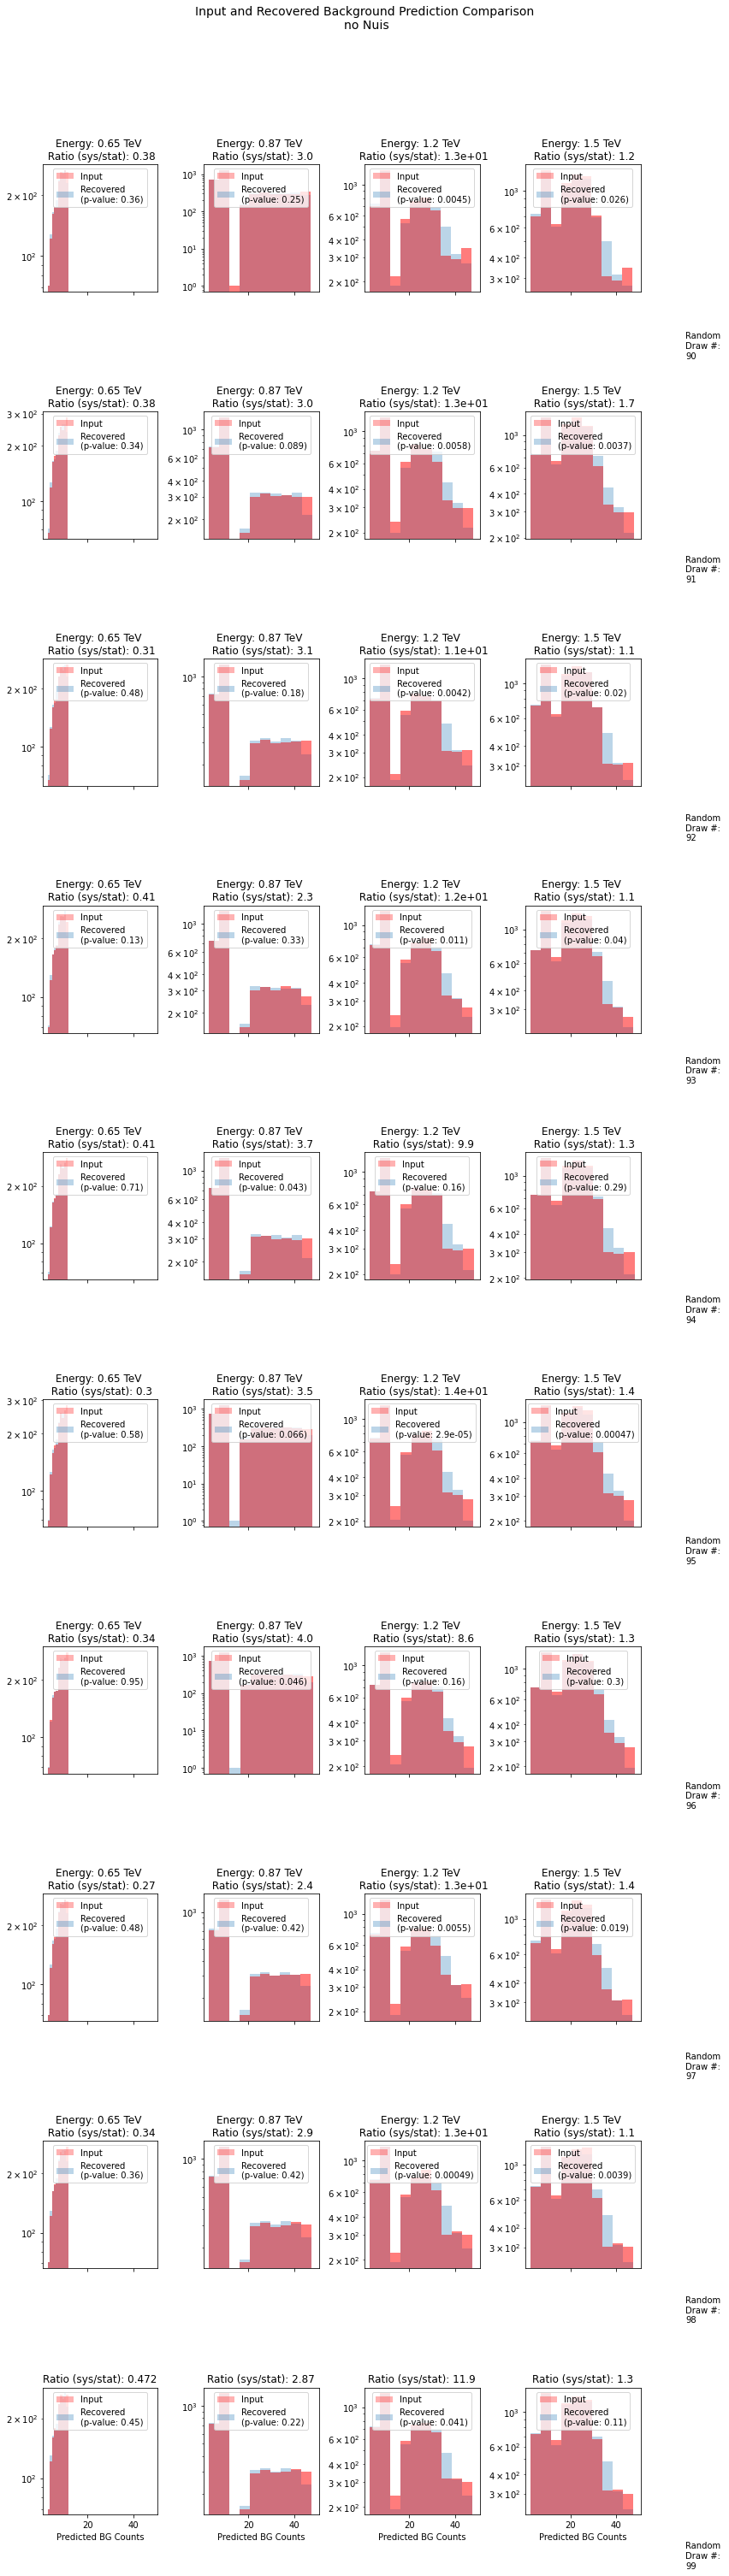

In [26]:

tupels = [(d_f, mocked, np.nan, np.nan)  for d_f, mocked in zip (datasets_standard , mocked_dataset_s)]
par= plot_multiple_histo (tupels , elist,"bgpred")
plt.suptitle("Input and Recovered Background Prediction Comparison \nno Nuis",
             y=1.05, fontsize=14)

[ 0.37939155  2.998749   12.764532    1.2312858 ]
[ 0.37935662  2.9560845  13.277194    1.6638167 ]
[ 0.31179953  3.0521607  11.247159    1.1424927 ]
[ 0.41495204  2.3324842  12.420772    1.1128167 ]
[0.4076006 3.6700864 9.940226  1.2885925]
[ 0.30171353  3.5163658  13.534066    1.420513  ]
[0.34426117 4.0348606  8.64053    1.3326895 ]
[ 0.2718147  2.4350252 13.015899   1.4462969]
[ 0.33704686  2.8843908  12.624829    1.1260965 ]
[ 0.47230738  2.8662145  11.902374    1.298244  ]


Text(0.5, 1.05, 'Input and Recovered Background Prediction \nCorr Est. ($\\mu$ +  $\\sigma$)')

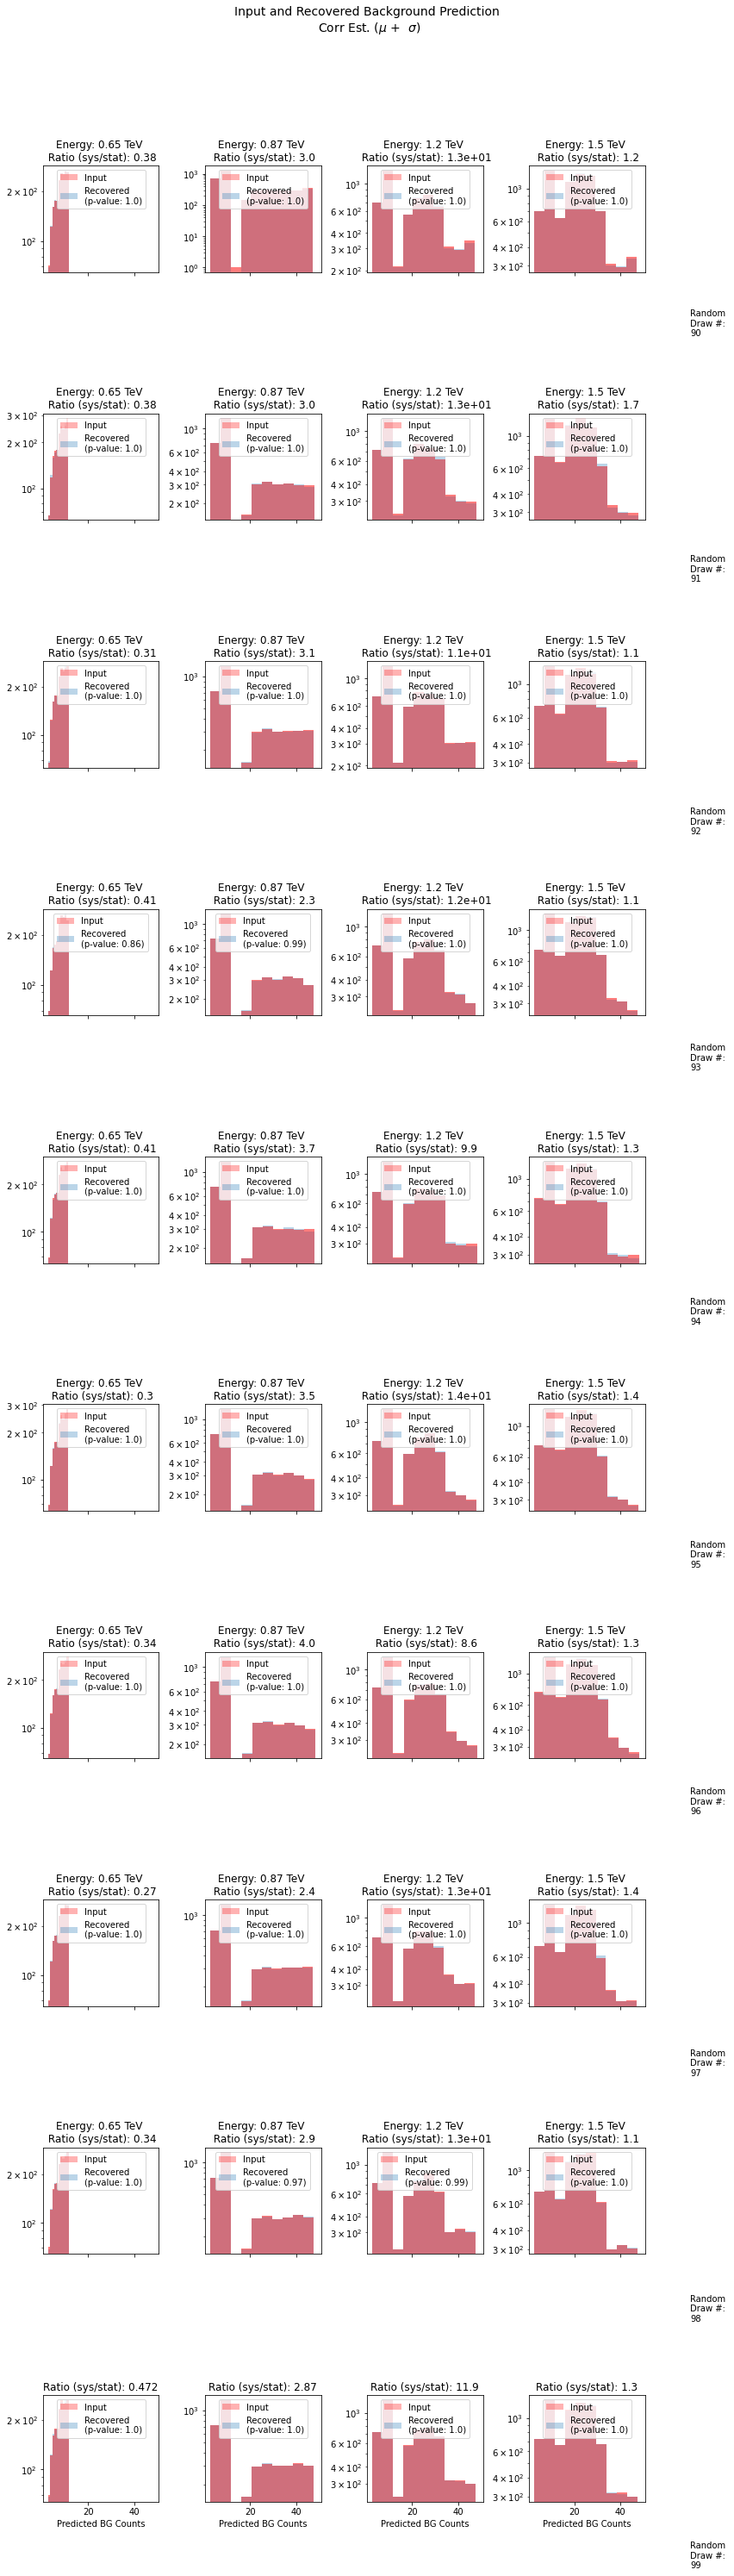

In [27]:
tupels = [(d_f, mocked, np.nan, np.nan)  for d_f, mocked in zip (datasets_corr,
                                                                 mocked_dataset_s)]
par= plot_multiple_histo (tupels , elist,"bgpred")
plt.suptitle("Input and Recovered Background Prediction \nCorr Est. ($\mu$ +  $\sigma$)",
             y=1.05, fontsize=14)

[ 0.37939155  2.998749   12.764532    1.2312858 ]
[ 0.37935662  2.9560845  13.277194    1.6638167 ]
[ 0.31179953  3.0521607  11.247159    1.1424927 ]
[ 0.41495204  2.3324842  12.420772    1.1128167 ]
[0.4076006 3.6700864 9.940226  1.2885925]
[ 0.30171353  3.5163658  13.534066    1.420513  ]
[0.34426117 4.0348606  8.64053    1.3326895 ]
[ 0.2718147  2.4350252 13.015899   1.4462969]
[ 0.33704686  2.8843908  12.624829    1.1260965 ]
[ 0.47230738  2.8662145  11.902374    1.298244  ]


Text(0.5, 1.05, 'Input and Recovered Background Prediction \nUnder Est. ($\\mu$ +  0.5 $\\sigma$)')

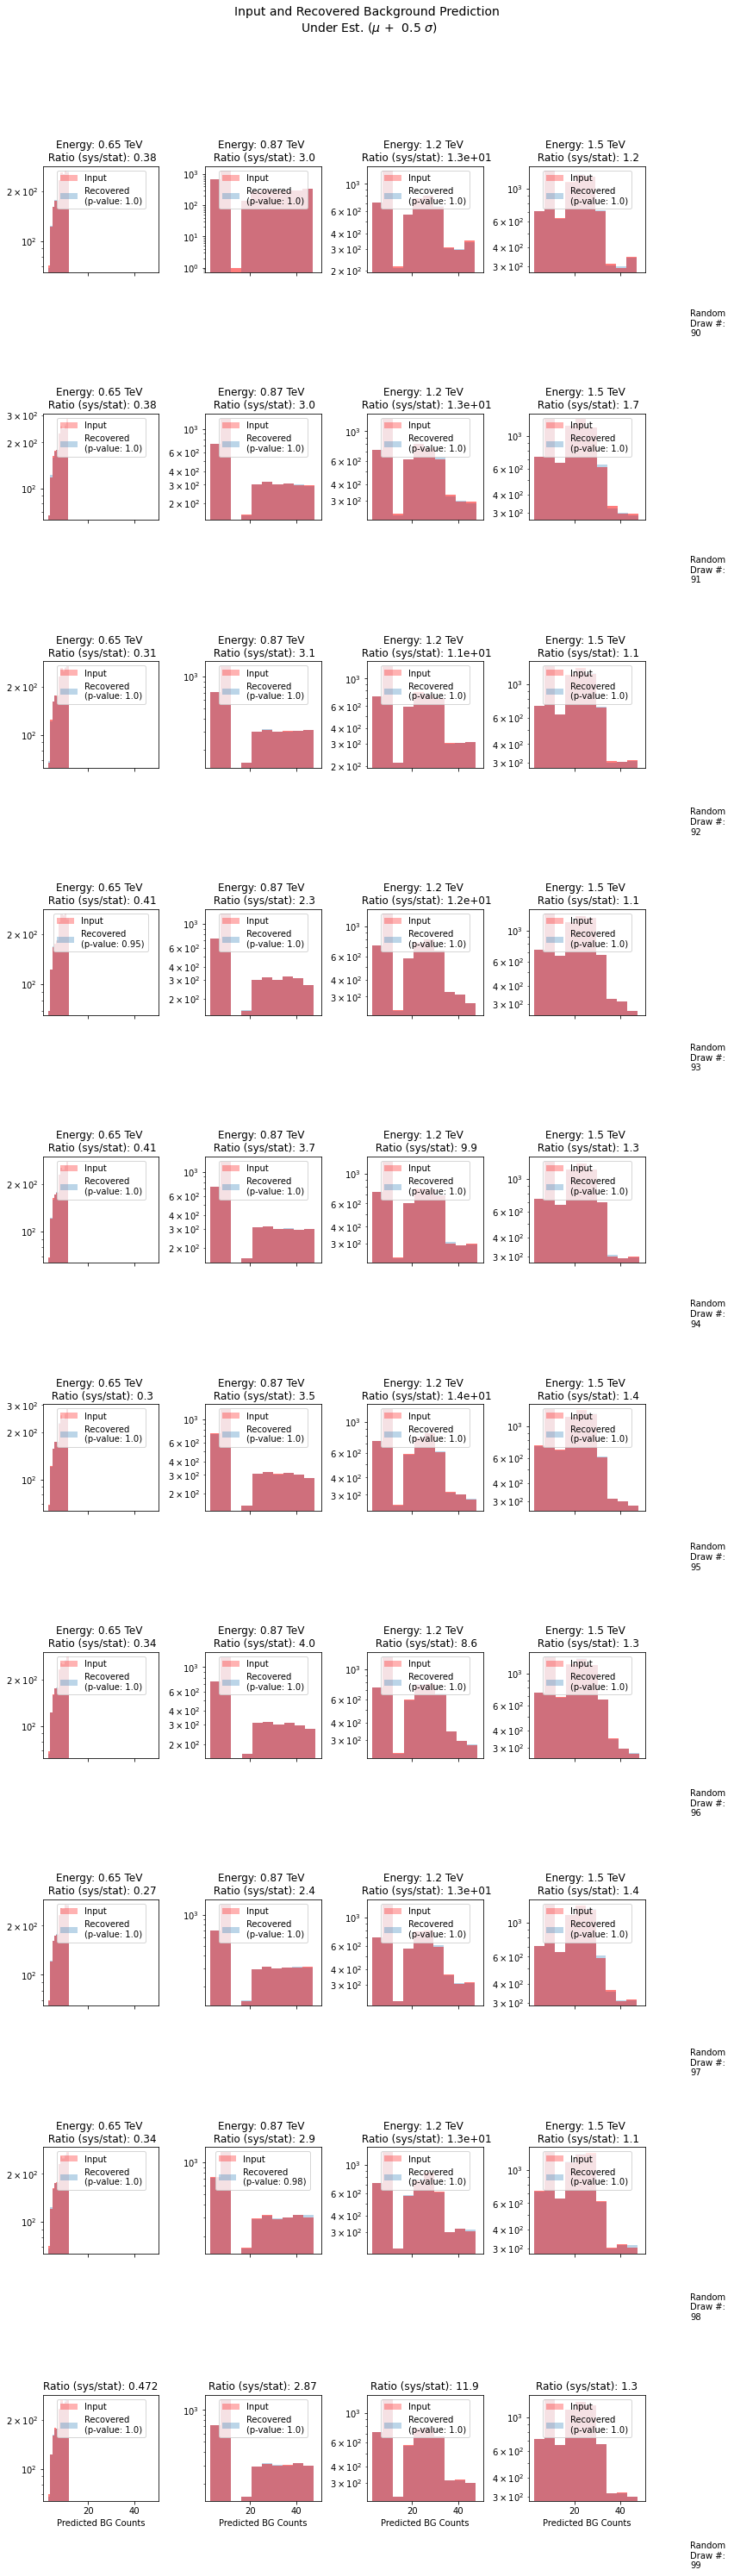

In [28]:
tupels = [(d_f, mocked, np.nan, np.nan)  for d_f, mocked in zip (datasets_under,
                                                                 mocked_dataset_s)]
par= plot_multiple_histo (tupels , elist,"bgpred")
plt.suptitle("Input and Recovered Background Prediction \nUnder Est. ($\mu$ +  0.5 $\sigma$)",
             y=1.05, fontsize=14)

[ 0.37939155  2.998749   12.764532    1.2312858 ]
[ 0.37935662  2.9560845  13.277194    1.6638167 ]
[ 0.31179953  3.0521607  11.247159    1.1424927 ]
[ 0.41495204  2.3324842  12.420772    1.1128167 ]
[0.4076006 3.6700864 9.940226  1.2885925]
[ 0.30171353  3.5163658  13.534066    1.420513  ]
[0.34426117 4.0348606  8.64053    1.3326895 ]
[ 0.2718147  2.4350252 13.015899   1.4462969]
[ 0.33704686  2.8843908  12.624829    1.1260965 ]
[ 0.47230738  2.8662145  11.902374    1.298244  ]


Text(0.5, 1.05, 'Input and Recovered Background Prediction Comparison \nCorr Est. ($\\mu$ +  $\\sigma$)')

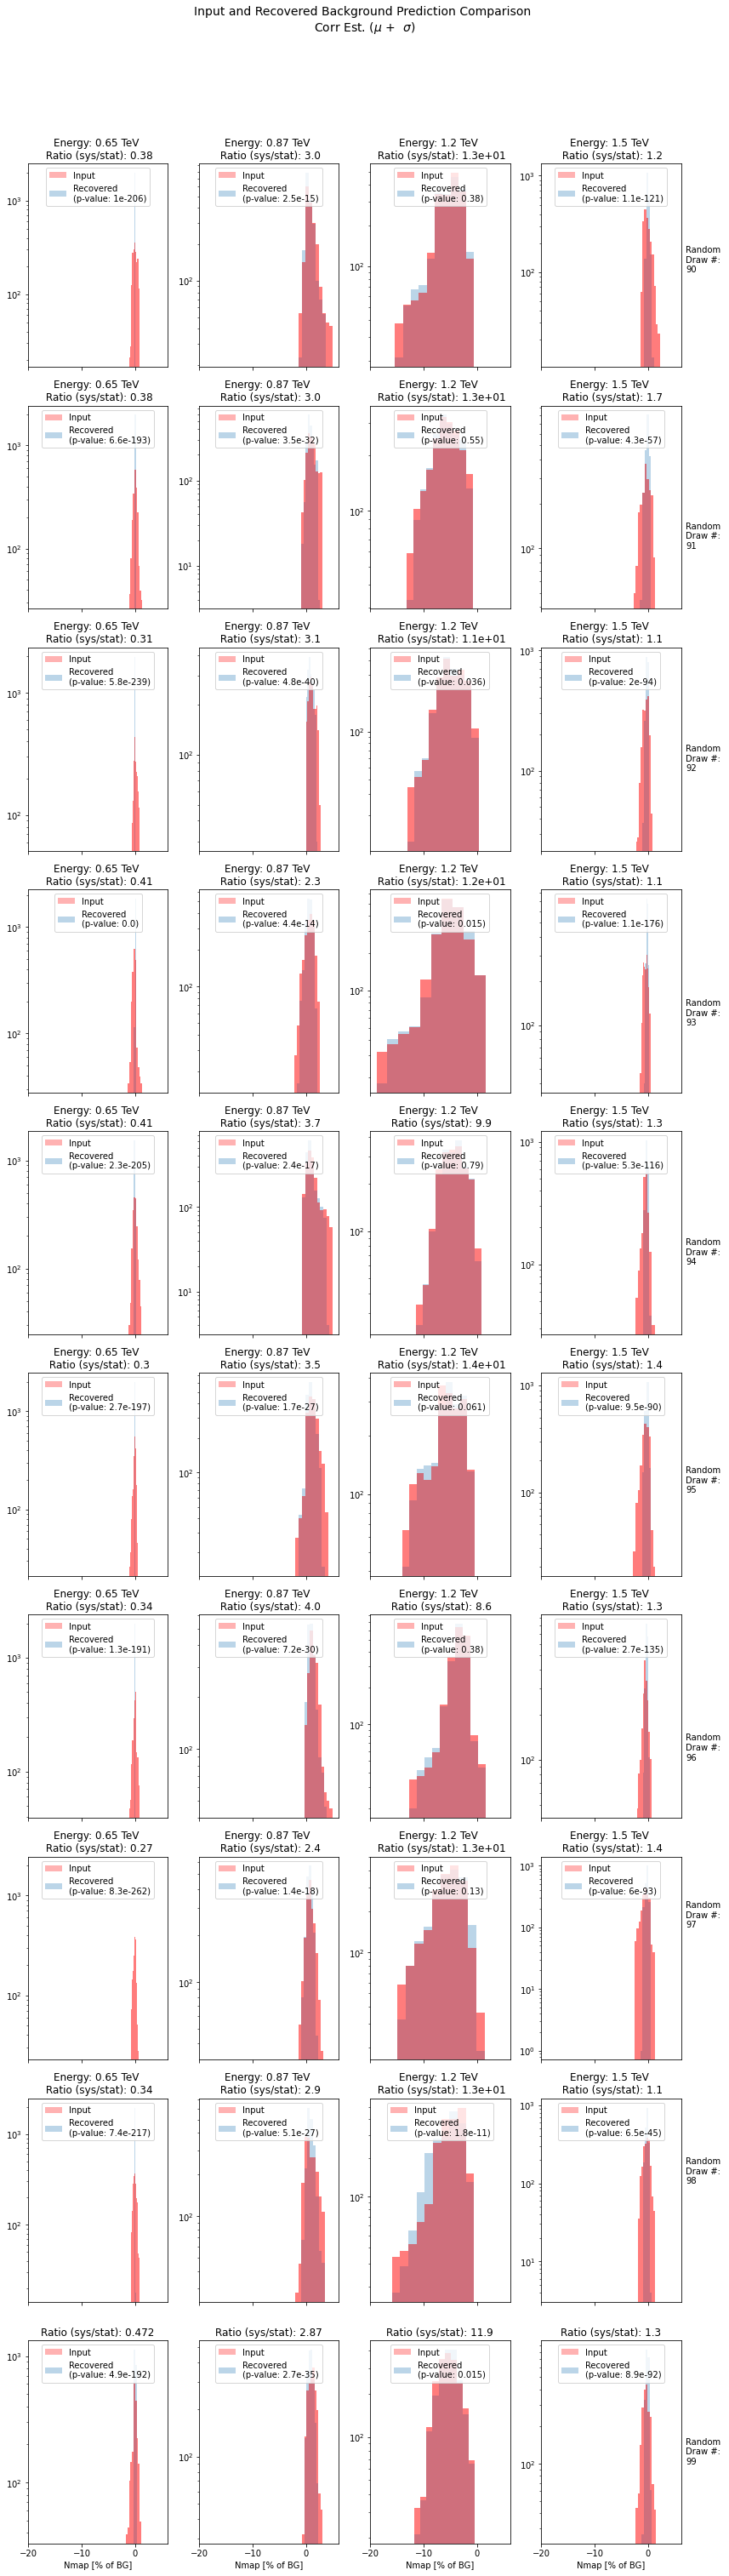

In [29]:
tupels = [(d_f, mocked, np.nan, np.nan)  for d_f, mocked in zip (datasets_corr,
                                                                 mocked_dataset_s)]
par= plot_multiple_histo (tupels , elist,"sys")
plt.suptitle("Input and Recovered Background Prediction Comparison \nCorr Est. ($\mu$ +  $\sigma$)",
             y=1.05, fontsize=14)

[ 0.37939155  2.998749   12.764532    1.2312858 ]
[ 0.37935662  2.9560845  13.277194    1.6638167 ]
[ 0.31179953  3.0521607  11.247159    1.1424927 ]
[ 0.41495204  2.3324842  12.420772    1.1128167 ]
[0.4076006 3.6700864 9.940226  1.2885925]
[ 0.30171353  3.5163658  13.534066    1.420513  ]
[0.34426117 4.0348606  8.64053    1.3326895 ]
[ 0.2718147  2.4350252 13.015899   1.4462969]
[ 0.33704686  2.8843908  12.624829    1.1260965 ]
[ 0.47230738  2.8662145  11.902374    1.298244  ]


Text(0.5, 1.05, 'Input and Recovered Background Prediction Comparison \nUnder Est. ($\\mu$ + 0.5  $\\sigma$)')

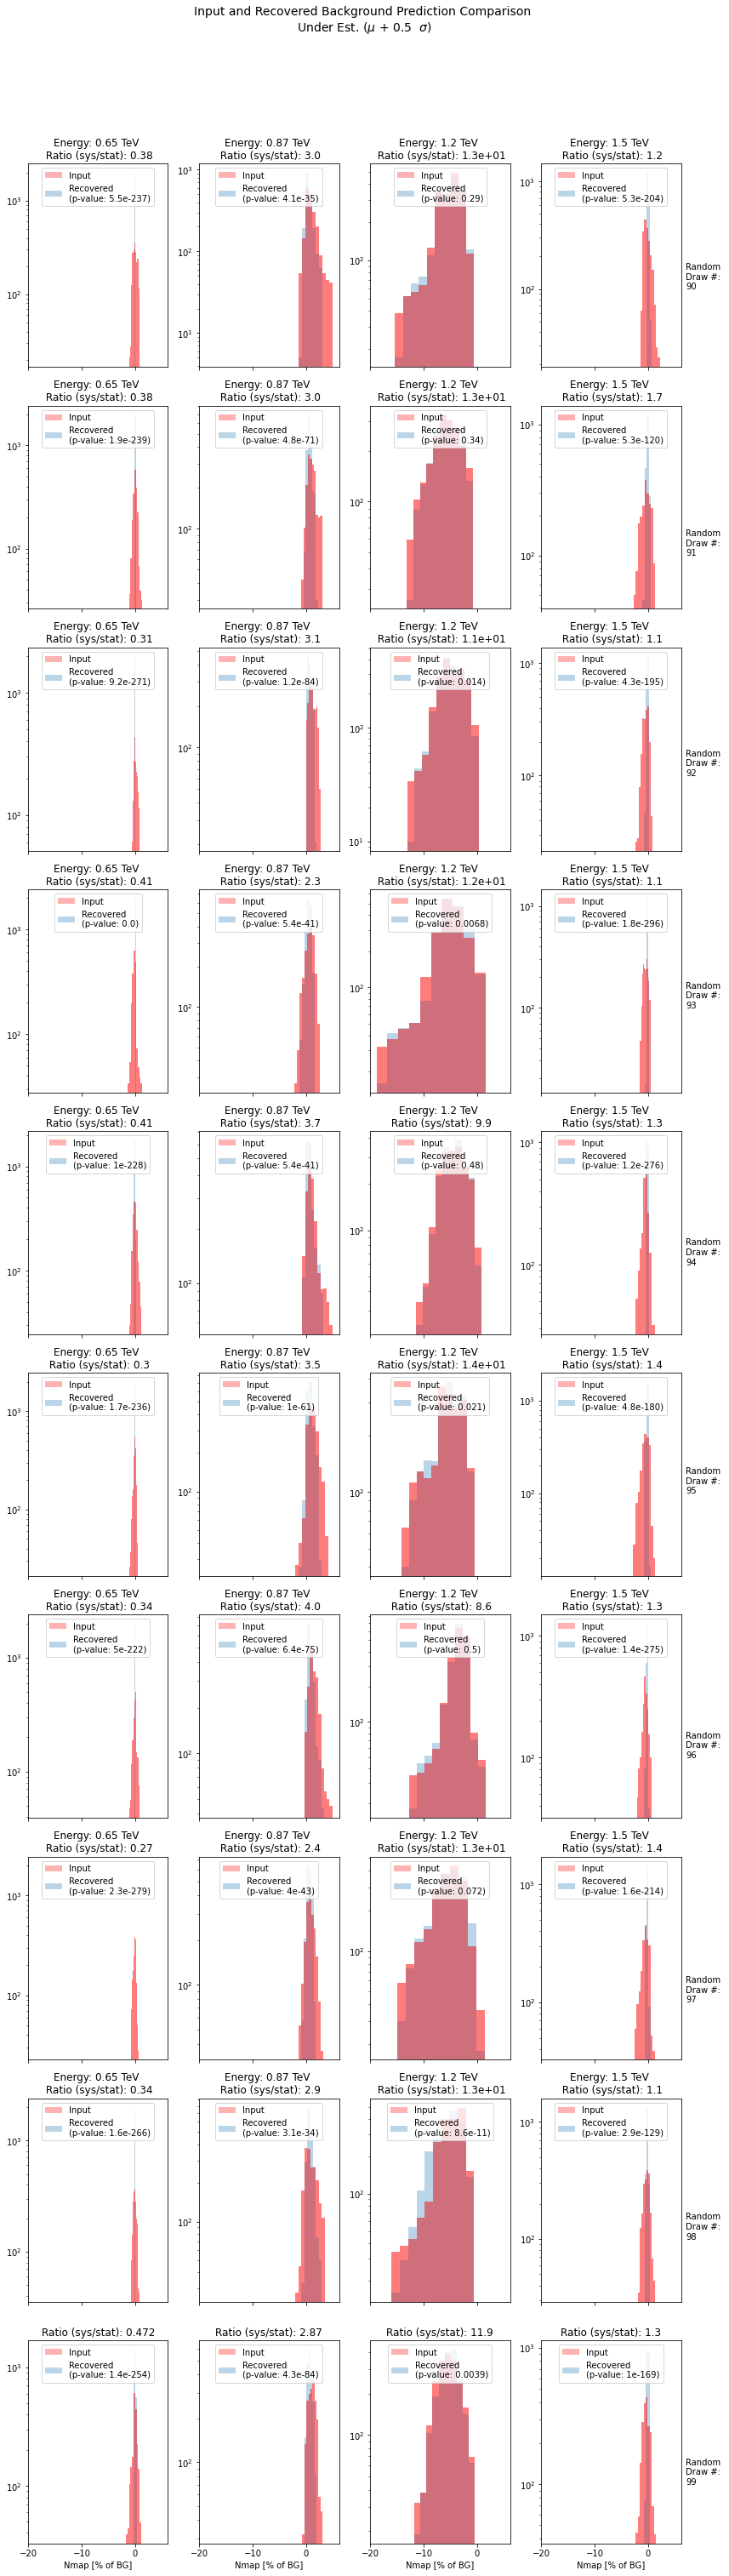

In [30]:
tupels = [(d_f, mocked, np.nan, np.nan)  for d_f, mocked in zip  (datasets_over,
                                                                 mocked_dataset_s)]
par= plot_multiple_histo (tupels , elist,"sys")
plt.suptitle("Input and Recovered Background Prediction Comparison \nUnder Est. ($\mu$ + 0.5  $\sigma$)",
             y=1.05, fontsize=14)

In [31]:

                
        
def plot_bg_p_value_multiple (tupels, elist, type_,):
    fig, axs = plt.subplots(1, 1, figsize =(10, 3* 1) ,
                           sharex = True)
    #syss = [sys_a, sys_b, sys_c]
    for i,e in enumerate(xaxis[i_start:i_end]):
        ps, ps_under, ps_over, ps_standard, ratio = [], [],[],[],[]
        for j,tupel in enumerate(tupels):
            ax = axs
            dataset_fitting = tupel[0]
            mocked = tupel[1]
            dataset = mocked.dataset_N_sys
            mus = tupel[2]
            stds = tupel[3]
            dataset_under = tupel[4]
            dataset_over= tupel[5]
            dataset_standard = tupel[6]
            
            if type_ =='bgpred':
                i_ = i+i_start
                title = 'Predicted BG Counts Accuracy'
                pos = -0.1
            if type_ =='nuipar':
                i_ = i 
                title = 'Nuisance Parameter Accuracy'
                pos = -0.05
            if type_ =='sys':
                i_ = i+ i_start
                title = 'Nuisance Parameter Accuracy'
                pos = -0.05
            input_ =  get_data_to_plot(dataset, mocked, type_, i_, i_+1)
            rec = get_data_to_plot(dataset_fitting, None, type_, i_, i_+1)
            KS, p = ks_2samp(input_, rec, alternative='two-sided',)
            ps.append(p)
            ratio.append(compute_ratio(dataset ,mocked)[i])
            
            if dataset_under is not None:
                rec = get_data_to_plot(dataset_under, None, type_,i_, i_+1)
                KS, p = ks_2samp(input_, rec, alternative='two-sided', )
                ps_under.append(p)
            if dataset_over is not None:
                rec = get_data_to_plot(dataset_over, None, type_, i_, i_+1)
                KS, p = ks_2samp(input_, rec, alternative='two-sided', )
                ps_over.append(p)
            if ((dataset_standard is not None) and  (type_ =='bgpred')):
                rec = get_data_to_plot(dataset_standard, None, type_, i_, i_+1)
                KS, p = ks_2samp(input_, rec, alternative='two-sided', )
                ps_standard.append(p)
            else:
                ps_standard = [0]
            
        if i ==0:
            label = 'Correct Est. ($\mu$ +  $\sigma$)'
            labelunder = "Under Est. ($\mu$ + 0.5 $\cdot$ $\sigma$)"
            labelover =  "Over Est. ($\mu$ + 2 $\cdot$ $\sigma$)"
            labelstandard = "No Nuisance Par. "
        else:
            label, labelunder, labelover, labelstandard = '' ,'','', ''
        asymmetric_error_under = np.array(list(zip([np.std(ratio)-0.1] ,
                                                   [np.std(ratio)+0.1]))).T
        asymmetric_error_over = np.array(list(zip([np.std(ratio)+0.1] ,
                                                   [np.std(ratio)-0.1]))).T
        
        xs = [np.mean(ratio) - 0.1,  np.mean(ratio), np.mean(ratio) + 0.1,  np.mean(ratio)]
        ys = [np.mean(ps_under), np.mean(ps), np.mean(ps_over),np.mean(ps_standard)]
        xerrs = [ asymmetric_error_under, np.std(ratio), asymmetric_error_over, np.std(ratio)]
        yerrs = [np.std(ps_under), np.std(ps), np.std(ps_over), np.std(ps_standard) ]
        labels = [labelunder, label, labelover, labelstandard]
        markers = ['o', 'x', 's', '*']
        for k in np.arange(len(xs[:-1])):
            markersize = 7 
            if k ==1:
                markersize = 10
            ax.errorbar(x= xs[k],y = ys[k] , yerr= yerrs[k] , 
                    xerr= xerrs[k], color = colors_case[k], ecolor = colors_e[i],
                    label =labels[k] , marker = markers[k],  markersize = markersize,)
        ax.errorbar(x= xs[3],y = ys[3] , yerr= yerrs[3] , 
                    xerr= xerrs[3], color = colors_e[i], ecolor = colors_e[i],
                    label =labels[3] , marker = markers[3],  markersize = 10,)
            
        ax.legend(loc = 'lower right')
        offset = 0.4
        if i==2:
            offset= 0.7
        ax.text(np.mean(ratio)-offset, 1.1, f"Energy: \n{e:.2}", color = colors_e[i])
    
    ax.set_title(title)
    ax.set_xlabel("Ratio Systematics / Statistics")
    ax.set_ylabel("P-Value")
    xlim = ax.get_xlim()
    ax.hlines(1, xlim[0], xlim[1], color ='grey')
    ax.hlines(0.95, xlim[0], xlim[1], color ='grey')
    ax.text(xlim[1]-0.2, pos, f"N= {len(tupels)}")
    ax.set_ylim(ax.get_ylim()[0], 1.2)
    


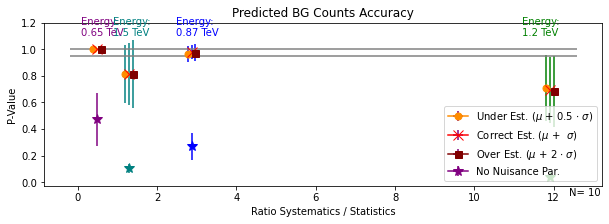

In [32]:
#colors_e = ['purple' , 'darkblue', 'darkgreen']
colors_e = ['purple' , 'blue', 'green', 'teal', 'crimson' ]

tupels = [(datasets_corr[i], mocked_dataset_, np.nan, np.nan,datasets_under[i],
           datasets_over[i], datasets_standard[i])  for i in range(len(datasets_corr))]



plot_bg_p_value_multiple(tupels, elist, 'bgpred')

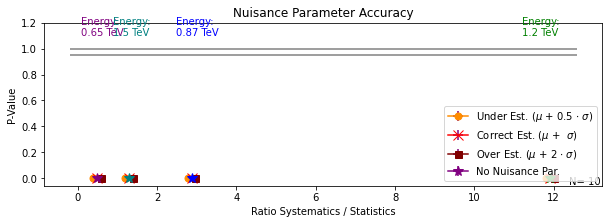

In [33]:
tupels = [(datasets_corr[i], mocked_dataset_, np.nan, np.nan,datasets_under[i],
           datasets_over[i], datasets_standard[i])  for i in range(len(datasets_corr))]




plot_bg_p_value_multiple(tupels, elist, 'sys')

In [34]:
colors_e_input = ['magenta' , 'blue', 'green', 'teal']
colors_e_input = colors_e

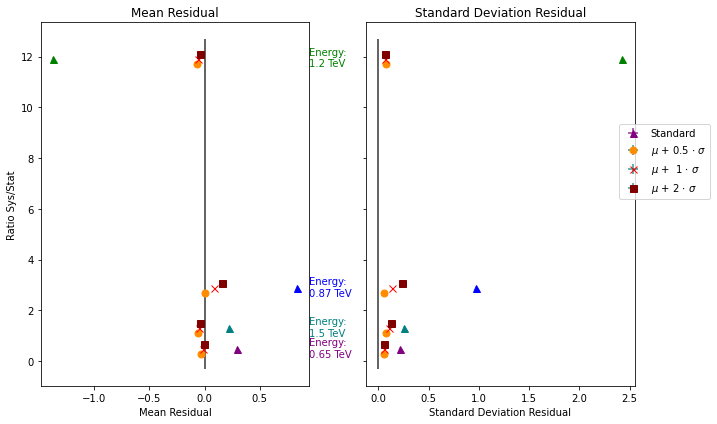

In [35]:
def plot_mean_std_multiple (tupels):
    fig, axs = plt.subplots(1, 2, figsize =(10, 6) , sharey = True
                           )
    rr = []
    for i, e in enumerate(elist):
        e = int(e)
        means_before_temp, stds_before_temp = [],[]
        means_after_temp, stds_after_temp = [],[]
        means_after_under, stds_after_under = [],[]
        means_after_over, stds_after_over = [],[]
        ratio = []
        for j,tupel in enumerate(tupels):
            
            res_standard_zero , res_standard_best_fit= tupel[0], tupel[1]
            alpha , res_under, res_over= tupel[2], tupel[3], tupel[4]
            mocked = tupel[5]
            res_before = res_standard_zero.slice_by_idx(dict(energy=slice(i,i+1))).data.flatten()
            res_after = res_standard_best_fit.slice_by_idx(dict(energy=slice(i,i+1))).data.flatten()
            if res_under is not None:
                res_under_ = res_under.slice_by_idx(dict(energy=slice(i,i+1))).data.flatten()
                means_after_under.append(np.nanmean(res_under_))
                stds_after_under.append(np.nanstd(res_under_))
            if res_over is not None:
                res_over_ = res_over.slice_by_idx(dict(energy=slice(i,i+1))).data.flatten()
                means_after_over.append(np.nanmean(res_over_))
                stds_after_over.append(np.nanstd(res_over_))
            
            means_before_temp.append(np.nanmean(res_before)); stds_before_temp.append(np.nanstd(res_before))
            means_after_temp.append(np.nanmean(res_after)); stds_after_temp.append(np.nanstd(res_after))
            ratio.append(compute_ratio(mocked.dataset_N_sys, mocked)[i])
        shift, alpha = 0.2 , 0.8
        asymmetric_error_under = np.array(list(zip([np.std(ratio)-shift] ,[np.std(ratio)+shift]))).T
        asymmetric_error_over = np.array(list(zip([np.std(ratio)+shift] ,[np.std(ratio)-shift]))).T
        ys = [np.mean(ratio), np.mean(ratio)-shift, np.mean(ratio), np.mean(ratio)+shift, ]
        yerrs = [ np.std(ratio),  asymmetric_error_under,np.std(ratio),asymmetric_error_over ]
        xs = [np.mean(means_before_temp),np.mean(means_after_under),np.mean(means_after_temp), np.mean(means_after_over) ]
        xerrs = [ np.std(means_before_temp), np.std(means_after_under) ,np.std(means_after_temp), np.std(means_after_over)]
        for c in range(len(ys)):
            if c == 0:
                colors = colors_e_input
                ecolor = colors_e_input
                label = "Standard"
                markers, caps, bars =axs[0].errorbar(y=  ys[c], x = xs[c] ,
                       yerr = yerrs[c], xerr = xerrs[c] ,fmt=fmts[c],
                       #color = colors[i], 
                        markersize = 7, label = label,
                        color = colors[i], ecolor = ecolor[i]);
                [bar.set_alpha(alpha) for bar in bars]
                [cap.set_alpha(alpha) for cap in caps] 
            else:
                colors =  colors_case
                ecolor =  colors_e
                if i ==(len(elist)-1):
                    labels = ['$\mu$ + 0.5 $\cdot$ $\sigma$', "$\mu$ +  1 $\cdot$ $\sigma$", "$\mu$ + 2 $\cdot$ $\sigma$"]
                    label = labels[c-1]
                else:
                    label = ''
                markers, caps, bars =axs[0].errorbar(y=  ys[c], x = xs[c] ,
                       yerr = yerrs[c], xerr = xerrs[c] ,fmt=fmts[c],
                       #color = colors[i], 
                        markersize = 7, label = label,
                        color = colors[c-1], ecolor = ecolor[i]); 
            
                [bar.set_alpha(alpha) for bar in bars]
                [cap.set_alpha(alpha) for cap in caps] 
        
        ys = [np.mean(ratio), np.mean(ratio)-shift, np.mean(ratio),np.mean(ratio)+shift,]
        yerrs = [ np.std(ratio),  asymmetric_error_under,np.std(ratio),asymmetric_error_over ]
        xs = [np.mean(stds_before_temp),np.mean(stds_after_under),np.mean(stds_after_temp), np.mean(stds_after_over) ]
        xerrs = [ np.std(stds_before_temp), np.std(stds_after_under) ,np.std(stds_after_temp), np.std(stds_after_over)]
        cases =["input" , 'under', 'cor', 'over']
        for c in range(len(ys)):
            if c == 0:
                colors = colors_e_input
                ecolor = colors_e_input
                if i == 0 :
                    label = "Standard"
                else:
                    label = ''
                markers, caps, bars =axs[1].errorbar(y=  ys[c], x = xs[c] ,
                       yerr = yerrs[c], xerr = xerrs[c] ,fmt=fmts[c],
                       #color = colors[i], 
                        markersize = 7, label = label,
                        color = colors[i], ecolor = ecolor[i]);
                [bar.set_alpha(alpha) for bar in bars]
                [cap.set_alpha(alpha) for cap in caps] 
            else:
                colors =  colors_case
                ecolor =  colors_e
                if i ==(len(elist)-1):
                    labels = ['$\mu$ + 0.5 $\cdot$ $\sigma$', "$\mu$ +  1 $\cdot$ $\sigma$", "$\mu$ + 2 $\cdot$ $\sigma$"]
                    label = labels[c-1]
                else:
                    label = ''
                markers, caps, bars =axs[1].errorbar(y=  ys[c], x = xs[c] ,
                       yerr = yerrs[c], xerr = xerrs[c] ,fmt=fmts[c],
                       #color = colors[i], 
                        markersize = 7, label = label,
                        color = colors[c-1], ecolor = ecolor[i]); 
            
                [bar.set_alpha(alpha) for bar in bars]
                [cap.set_alpha(alpha) for cap in caps] 
        rr.append(ratio)
        
    #axs[0].legend(loc = 'lower left', bbox_to_anchor=(1, 0.7))
    axs[0].set_title(f'Mean Residual')
    axs[0].set_xlabel("Mean Residual")
    axs[0].set_ylabel("Ratio Sys/Stat")
    axs[1].legend(loc= 'lower right',bbox_to_anchor=(1.3, 0.5))
    axs[1].set_title(f'Standard Deviation Residual')
    axs[1].set_xlabel("Standard Deviation Residual")
    #axs[1].set_ylabel("Ratio Sys/Stat")
    xx = axs[0].get_xlim()
    for i, e in enumerate(elist):
        
        axs[0].text(xx[1], np.mean(rr[i])-0.3,
                    f"Energy: \n{xaxis[i+i_start].value:.2} TeV", color = colors_e[i] )    
        #axs[1].text(0.1, np.mean(ratio)-0.3,
        #            f"Energy: {xaxis[i+i_start].value:.2} TeV", color = colors_e[i] ) 
    xlim = axs[1].get_xlim()
    #axs[1].set_xlim(-0.025, 0.2)
    ylim = axs[0].get_ylim()
    axs[0].vlines(0, ylim[0], ylim[1], color = 'black',alpha = 0.8)
    #ylim = axs[1].get_ylim()
    axs[1].vlines(0, ylim[0], ylim[1], color = 'black',alpha = 0.8)
        

    plt.tight_layout()
    
ress_zero_A=  [compute_residual(create_MapDataset(datasets_standard[0]), energy_edges) for i in range(len(datasets_standard))]
ress_A = [compute_residual(create_MapDataset(datasets_corr[0]), energy_edges)for i in range(len(datasets_standard))]
ress_A_under = [compute_residual(create_MapDataset(datasets_under[0]), energy_edges) for i in range(len(datasets_standard))]
ress_A_over = [compute_residual(create_MapDataset(datasets_over[0]), energy_edges) for i in range(len(datasets_standard))]


tupel = [(ress_zero_A[i], ress_A[i] , np.nan, ress_A_under[i]
          , ress_A_over[i],
         mocked_dataset_) for i in range(len(ress_A))]
plot_mean_std_multiple(tupel)

## Other Residual Comparison

Text(0.5, 0, 'Significance $\\sigma$')

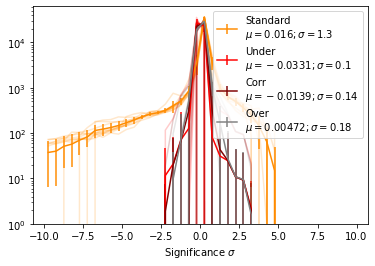